# Infilling COVID recovery data
First, we must clean the data. Several columns are not GHGs so we remove them. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyam
import silicone.utils
import silicone.database_crunchers as dc
import silicone.multiple_infillers as mi

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
input = pd.read_excel("../input/CompiledPiersScenarios_distri_with_cleaning_v2.xlsx", header=[0, 1])
sr15_data = silicone.utils.download_or_load_sr15("../input/complete_sr15.csv")
use_ar4_data = False
lead = "Emissions|Kyoto Gases (AR{}-GWP100)".format(4 if use_ar4_data else 5)
convert_n2o = (2 * 14 + 16) / (2 * 14) 
convert_co2 = (12 + 2 * 16) / 12
input

pyam.utils - INFO: Reading `../input/complete_sr15.csv`


,model,scenario,year,co2_fossil,co2_land,ch4,n2o,sox,co,nmvoc,...,mcf,hcfc22,hcfc141b,hcfc142b,halon1211,halon1202,halon1301,halon2402,ch3br,ch3cl
,Unnamed: 0_level_1,Unnamed: 1_level_1,Unnamed: 2_level_1,GtC/yr,GtC/yr,Mt/yr,Mt/yr [units of N],Mt/yr [units of S],Mt/yr,Mt/yr,...,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr,kt/yr
0,emissions_ndc_month_base,Baseline,2020,9.401228,1.384467,324.937346,6.081999,35.540802,756.389584,167.700559,...,0,444.821,57.463,18.867,2.531,0,0.911,0.055,155.925,3511.082
1,emissions_ndc_month_base,Baseline,2030,10.406026,0.858738,338.217710,6.750341,34.062300,721.864751,161.375566,...,0,472.764,58.080,9.424,1.225,0,0.545,0.017,155.925,3511.082
2,emissions_ndc_month_base,Baseline,2040,11.224362,0.211322,316.024645,6.862659,28.229820,652.913333,149.261614,...,0,240.141,44.431,4.563,0.593,0,0.326,0.005,155.925,3511.082
3,emissions_ndc_month_base,Baseline,2050,11.661349,-0.104809,303.546483,7.079232,23.515683,577.496078,138.737049,...,0,59.657,26.602,1.982,0.287,0,0.195,0.002,155.925,3511.082
4,emissions_ndc_month_g1_3,Green-recovery,2020,9.398041,1.383998,324.935053,6.081113,35.530899,756.380534,167.684500,...,0,444.821,57.463,18.867,2.531,0,0.911,0.055,155.925,3511.082
5,emissions_ndc_month_g1_3,Green-recovery,2030,6.671190,0.553782,217.080547,4.330161,21.865040,463.442623,103.611824,...,0,472.764,58.080,9.424,1.225,0,0.545,0.017,155.925,3511.082
6,emissions_ndc_month_g2_2,Fossil-recovery,2020,9.398041,1.383998,324.935053,6.081113,35.530899,756.380534,167.684500,...,0,444.821,57.463,18.867,2.531,0,0.911,0.055,155.925,3511.082
7,emissions_ndc_month_g2_2,Fossil-recovery,2030,11.446629,0.944612,372.039481,7.425375,37.468530,794.051226,177.513122,...,0,472.764,58.080,9.424,1.225,0,0.545,0.017,155.925,3511.082
8,emissions_ndc_month_g2_2,Fossil-recovery,2040,12.346798,0.232455,347.627110,7.548925,31.052802,718.204666,164.187775,...,0,240.141,44.431,4.563,0.593,0,0.326,0.005,155.925,3511.082


We need to reshape this into the correct structure for pyam

In [3]:
input = input.set_index(keys=[input.columns[0], input.columns[1], input.columns[2]])

In [4]:
input = input.stack(level=[0, 1]).reset_index()
input

,"(model, Unnamed: 0_level_1)","(scenario, Unnamed: 1_level_1)","(year, Unnamed: 2_level_1)",level_3,level_4,0
0,emissions_ndc_month_base,Baseline,2020,bc,Mt/yr,5.768693
1,emissions_ndc_month_base,Baseline,2020,c2f6,kt/yr,1.557000
2,emissions_ndc_month_base,Baseline,2020,c6f14,kt/yr,0.347200
3,emissions_ndc_month_base,Baseline,2020,carb_tet,kt/yr,0.000000
4,emissions_ndc_month_base,Baseline,2020,cf4,kt/yr,10.949979
...,...,...,...,...,...,...
385,emissions_ndc_month_g2_2,Fossil-recovery,2050,nmvoc,Mt/yr,152.610754
386,emissions_ndc_month_g2_2,Fossil-recovery,2050,nox,Mt/yr [units of N],32.716244
387,emissions_ndc_month_g2_2,Fossil-recovery,2050,oc,Mt/yr,22.653088
388,emissions_ndc_month_g2_2,Fossil-recovery,2050,sf6,kt/yr,2.458390


In [5]:
input = input.rename(
    {
        input.columns[0]: "model", 
        input.columns[1]: "scenario", 
        input.columns[2]: "year", 
        input.columns[3]: "variable",
        input.columns[4]: "unit", 
        input.columns[5]: "value"
    }, 
    axis= 1)
input["region"] = "World"

In [6]:
input_df = pyam.IamDataFrame(input)
unwanted_cols = ["sox", "co", "nmvoc", "nox", "bc", "oc", "nh3", "cfc113", "carb_tet", "cfc114", "mcf", "halon1202"]
input_df.filter(variable=unwanted_cols, keep=False, inplace=True)
input_df.data.head(30)

,model,scenario,region,variable,unit,year,value
4,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2020,1.557000
5,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2030,1.549600
6,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2040,1.465300
7,emissions_ndc_month_base,Baseline,World,c2f6,kt/yr,2050,1.366600
8,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2020,0.347200
9,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2030,0.345400
10,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2040,0.326700
11,emissions_ndc_month_base,Baseline,World,c6f14,kt/yr,2050,0.304700
16,emissions_ndc_month_base,Baseline,World,cf4,kt/yr,2020,10.949979
17,emissions_ndc_month_base,Baseline,World,cf4,kt/yr,2030,9.483124


Convert units. We need to change the format of the unit names first so they are recognised by pyam. 

In [7]:
input_df.convert_unit("Mt/yr [units of N]", "Mt/yr", convert_n2o, inplace=True)
input_df.convert_unit("GtC/yr", "GtCO2/yr", convert_co2, inplace=True)

In [8]:
orig_units = input_df.variables(True)
unit_rename_dict = {
    orig_units["variable"].iloc[i]: orig_units["unit"].iloc[i][:2] + " " + 
    orig_units["variable"].iloc[i].upper().replace("_FOSSIL", "").replace("_LAND", "").replace("HFC43_10", "HFC4310mee") + "/yr" for i in range(len(orig_units))
}

In [9]:
for i in input_df.data.index:
    input_df.data.loc[i, "unit"] = unit_rename_dict[input_df.data.loc[i, "variable"]]

In [10]:
input_df.data

,model,scenario,region,variable,unit,year,value
4,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2020,1.557000
5,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2030,1.549600
6,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2040,1.465300
7,emissions_ndc_month_base,Baseline,World,c2f6,kt C2F6/yr,2050,1.366600
8,emissions_ndc_month_base,Baseline,World,c6f14,kt C6F14/yr,2020,0.347200
...,...,...,...,...,...,...,...
365,emissions_ndc_month_g2_2,Fossil-recovery,World,n2o,Mt N2O/yr,2050,12.236958
382,emissions_ndc_month_g2_2,Fossil-recovery,World,sf6,kt SF6/yr,2020,6.318104
383,emissions_ndc_month_g2_2,Fossil-recovery,World,sf6,kt SF6/yr,2030,6.659998
384,emissions_ndc_month_g2_2,Fossil-recovery,World,sf6,kt SF6/yr,2040,2.960982


In [11]:
converted_input = silicone.utils.convert_units_to_MtCO2_equiv(input_df, use_ar4_data=use_ar4_data)

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated an

In [12]:
converted_input.filter(year=2020, scenario="Baseline").data.head(10)

,model,scenario,region,variable,unit,year,value
4,emissions_ndc_month_base,Baseline,World,c2f6,Mt CO2-equiv/yr,2020,17.282700
8,emissions_ndc_month_base,Baseline,World,c6f14,Mt CO2-equiv/yr,2020,2.746352
16,emissions_ndc_month_base,Baseline,World,cf4,Mt CO2-equiv/yr,2020,72.598361
20,emissions_ndc_month_base,Baseline,World,cfc11,Mt CO2-equiv/yr,2020,143.178500
32,emissions_ndc_month_base,Baseline,World,cfc115,Mt CO2-equiv/yr,2020,0.076700
36,emissions_ndc_month_base,Baseline,World,cfc12,Mt CO2-equiv/yr,2020,154.846200
40,emissions_ndc_month_base,Baseline,World,ch3br,Mt CO2-equiv/yr,2020,0.311850
44,emissions_ndc_month_base,Baseline,World,ch3cl,Mt CO2-equiv/yr,2020,42.132984
48,emissions_ndc_month_base,Baseline,World,ch4,Mt CO2-equiv/yr,2020,9098.245702
56,emissions_ndc_month_base,Baseline,World,co2_fossil,Mt CO2-equiv/yr,2020,34471.170642


# Infilling the consistent units
We now need to construct a Kyoto total for this and can then split this into the relevant components. 

In [13]:
kyoto_input = silicone.utils._construct_consistent_values(
    lead, converted_input.variables().to_list(), converted_input
)
kyoto_gases = ["Emissions|CO2", "Emissions|N2O", "Emissions|F-Gases", "Emissions|CH4"]

In [14]:
kyoto_input.data.head()

,model,scenario,region,variable,unit,year,value
0,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2020,53929.700456
1,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2030,56373.414429
2,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2040,55732.303976
3,emissions_ndc_month_base,Baseline,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2050,55360.035208
4,emissions_ndc_month_g1_3,Green-recovery,World,Emissions|Kyoto Gases (AR5-GWP100),Mt CO2-equiv/yr,2020,53915.859422


In [15]:
# Infill the desired components using interpolation between the nearest MESSAGE-GLOBIOM SSP2 scenarios
infiller_df = sr15_data.filter(model="MESSAGE-GLOBIOM*", scenario="SSP2*")

These Kyoto totals will later be recalculated for consistency, but we will check that they are fairly consistent now anyway

In [16]:
# We also need to check that the calculated Kyoto totals agrees with the reported values in the database. 
corrected_infiller_df = silicone.utils._construct_consistent_values(
    lead, kyoto_gases, silicone.utils.convert_units_to_MtCO2_equiv(
        infiller_df.filter(variable=kyoto_gases), use_ar4_data=use_ar4_data
    )
)

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!


pyam.plotting - INFO: >=13 labels, not applying legend


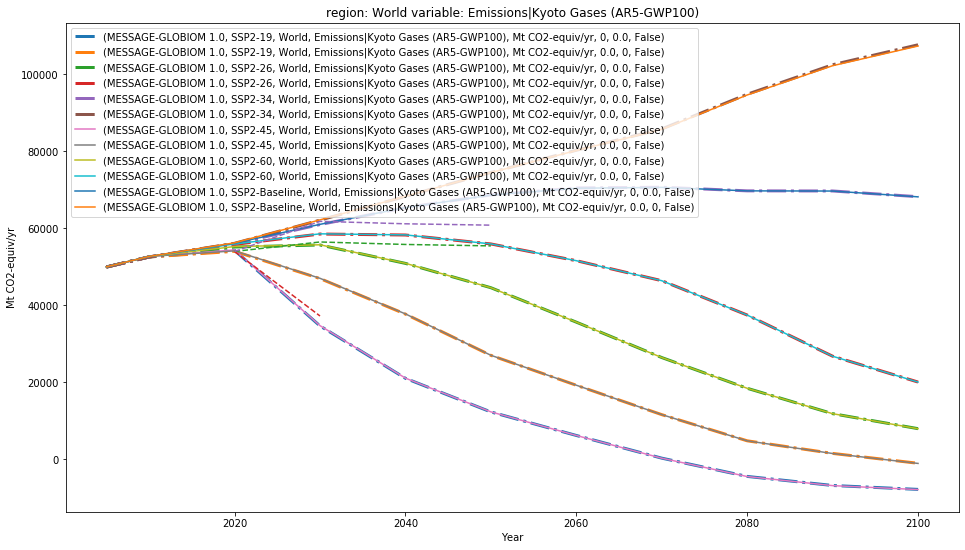

In [17]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
corrected_infiller_df.line_plot(ax=ax, linestyle="-.", linewidth = 3)
infiller_df.filter(variable=lead).line_plot(ax=ax)
kyoto_input.line_plot(ax=ax, linestyle="--")

Our reconstructed values are consistent with the originals. Since the emissions are within the limits of our known cases for our database, we can use the linear interpolation method to infill. 

In [18]:
desired_vars = [
    "Emissions|BC",
    "Emissions|CH4",
    "Emissions|CO2",
    "Emissions|CO2|Energy and Industrial Processes",
    "Emissions|CO2|AFOLU",
    "Emissions|CO",
    "Emissions|N2O",
    "Emissions|NH3",
    "Emissions|NOx",
    "Emissions|OC",
    "Emissions|F-Gases",
    #"Emissions|HFC",
    #"Emissions|PFC",
    #"Emissions|SF6",
    "Emissions|Sulfur",
    "Emissions|VOC"
]

In [19]:
infiller_df.variables(True)

,variable,unit
0,Emissions|BC,Mt BC/yr
1,Emissions|CH4,Mt CH4/yr
2,Emissions|CH4|AFOLU,Mt CH4/yr
3,Emissions|CH4|Energy,Mt CH4/yr
4,Emissions|CO,Mt CO/yr
5,Emissions|CO2,Mt CO2/yr
6,Emissions|CO2|AFOLU,Mt CO2/yr
7,Emissions|CO2|Energy and Industrial Processes,Mt CO2/yr
8,Emissions|CO2|Energy|Demand,Mt CO2/yr
9,Emissions|CO2|Energy|Demand|Industry,Mt CO2/yr


In [20]:
infilled = mi.infill_all_required_variables(
    kyoto_input, infiller_df, [lead], desired_vars, dc.LinearInterpolation
)
infilled.head()

Filling required variables:   0%|                                                               | 0/13 [00:00<?, ?it/s]c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\silicone-5\lib\site-packages\scipy\interpolate\interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\silicone-5\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
Filling required variables: 100%|██████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.20it/s]


,model,scenario,region,variable,unit,year,value
0,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2020,5.962082
1,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2030,5.560720
2,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2040,5.138917
3,emissions_ndc_month_base,Baseline,World,Emissions|BC,Mt BC/yr,2050,4.616196
4,emissions_ndc_month_base,Baseline,World,Emissions|CH4,Mt CH4/yr,2020,330.724996


In [21]:
infilled.timeseries()

2020  \
model                    scenario        region variable                                      unit                            
emissions_ndc_month_base Baseline        World  Emissions|BC                                  Mt BC/yr             5.962082   
                                                Emissions|CH4                                 Mt CH4/yr          330.724996   
                                                Emissions|CO                                  Mt CO/yr           786.902114   
                                                Emissions|CO2                                 Mt CO2/yr        40656.969190   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4437.784919   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36219.184280   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1491.783333   
                                                Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  53929.700456   
                                                Emissions|N2O                                 kt N2O/yr         9580.786088   
                                                Emissions|NH3                                 Mt NH3/yr           47.446506   
                                                Emissions|NOx                                 Mt NO2/yr          103.351816   
                                                Emissions|OC                                  Mt OC/yr            30.253298   
                                                Emissions|Sulfur                              Mt SO2/yr           76.106893   
                                                Emissions|VOC                                 Mt VOC/yr          178.092157   
emissions_ndc_month_g1_3 Green-recovery  World  Emissions|BC                                  Mt BC/yr             5.962082   
                                                Emissions|CH4                                 Mt CH4/yr          330.724996   
                                                Emissions|CO                                  Mt CO/yr           786.902114   
                                                Emissions|CO2                                 Mt CO2/yr        40656.969190   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4437.784919   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36219.184280   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1491.783333   
                                                Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  53915.859422   
                                                Emissions|N2O                                 kt N2O/yr         9580.786088   
                                                Emissions|NH3                                 Mt NH3/yr           47.446506   
                                                Emissions|NOx                                 Mt NO2/yr          103.351816   
                                                Emissions|OC                                  Mt OC/yr            30.253298   
                                                Emissions|Sulfur                              Mt SO2/yr           76.106893   
                                                Emissions|VOC                                 Mt VOC/yr          178.092157   
emissions_ndc_month_g2_2 Fossil-recovery World  Emissions|BC                                  Mt BC/yr             5.962082   
                                                Emissions|CH4                                 Mt CH4/yr          330.724996   
                                                Emissio

Check that values have split consistently:

In [22]:
silicone.utils.return_cases_which_consistently_split(
    infilled, lead, kyoto_gases, how_close={"equal_nan": True, "rtol": 1e-03}, use_ar4_data=use_ar4_data
)

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!


[('emissions_ndc_month_base', 'Baseline', 'World'),
 ('emissions_ndc_month_g1_3', 'Green-recovery', 'World'),
 ('emissions_ndc_month_g2_2', 'Fossil-recovery', 'World')]

# Append constructed value for green 2040 and 2050
All cases have been found. Now we want to infill the final time for green recovery. We define it as reaching 0 at time 2060. At 2040 it is therefore the value at 2030 * 2/3 or 1/3. 

In [23]:
CO2 = "Emissions|CO2"
row_to_add = infilled.filter(scenario='Green-recovery', year=2030, variable=CO2).data
row_to_add["year"] = 2040
row_to_add = row_to_add.append(row_to_add)
row_to_add = row_to_add.reset_index(drop=True)
row_to_add.loc[row_to_add.index[0], "value"] = row_to_add.loc[row_to_add.index[0], "value"] * 2 / 3
row_to_add.loc[row_to_add.index[1], "value"] = row_to_add.loc[row_to_add.index[1], "value"] * 1 / 3
row_to_add.loc[row_to_add.index[1], "year"] = 2050
row_to_add

,model,scenario,region,variable,unit,year,value
0,emissions_ndc_month_g1_3,Green-recovery,World,Emissions|CO2,Mt CO2/yr,2040,17236.721411
1,emissions_ndc_month_g1_3,Green-recovery,World,Emissions|CO2,Mt CO2/yr,2050,8618.360706


In [24]:
infilled.data = infilled.data.append(row_to_add)
infilled.timeseries()

2020  \
model                    scenario        region variable                                      unit                            
emissions_ndc_month_base Baseline        World  Emissions|BC                                  Mt BC/yr             5.962082   
                                                Emissions|CH4                                 Mt CH4/yr          330.724996   
                                                Emissions|CO                                  Mt CO/yr           786.902114   
                                                Emissions|CO2                                 Mt CO2/yr        40656.969190   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4437.784919   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36219.184280   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1491.783333   
                                                Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  53929.700456   
                                                Emissions|N2O                                 kt N2O/yr         9580.786088   
                                                Emissions|NH3                                 Mt NH3/yr           47.446506   
                                                Emissions|NOx                                 Mt NO2/yr          103.351816   
                                                Emissions|OC                                  Mt OC/yr            30.253298   
                                                Emissions|Sulfur                              Mt SO2/yr           76.106893   
                                                Emissions|VOC                                 Mt VOC/yr          178.092157   
emissions_ndc_month_g1_3 Green-recovery  World  Emissions|BC                                  Mt BC/yr             5.962082   
                                                Emissions|CH4                                 Mt CH4/yr          330.724996   
                                                Emissions|CO                                  Mt CO/yr           786.902114   
                                                Emissions|CO2                                 Mt CO2/yr        40656.969190   
                                                Emissions|CO2|AFOLU                           Mt CO2/yr         4437.784919   
                                                Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36219.184280   
                                                Emissions|F-Gases                             Mt CO2-equiv/yr   1491.783333   
                                                Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  53915.859422   
                                                Emissions|N2O                                 kt N2O/yr         9580.786088   
                                                Emissions|NH3                                 Mt NH3/yr           47.446506   
                                                Emissions|NOx                                 Mt NO2/yr          103.351816   
                                                Emissions|OC                                  Mt OC/yr            30.253298   
                                                Emissions|Sulfur                              Mt SO2/yr           76.106893   
                                                Emissions|VOC                                 Mt VOC/yr          178.092157   
emissions_ndc_month_g2_2 Fossil-recovery World  Emissions|BC                                  Mt BC/yr             5.962082   
                                                Emissions|CH4                                 Mt CH4/yr          330.724996   
                                                Emissio

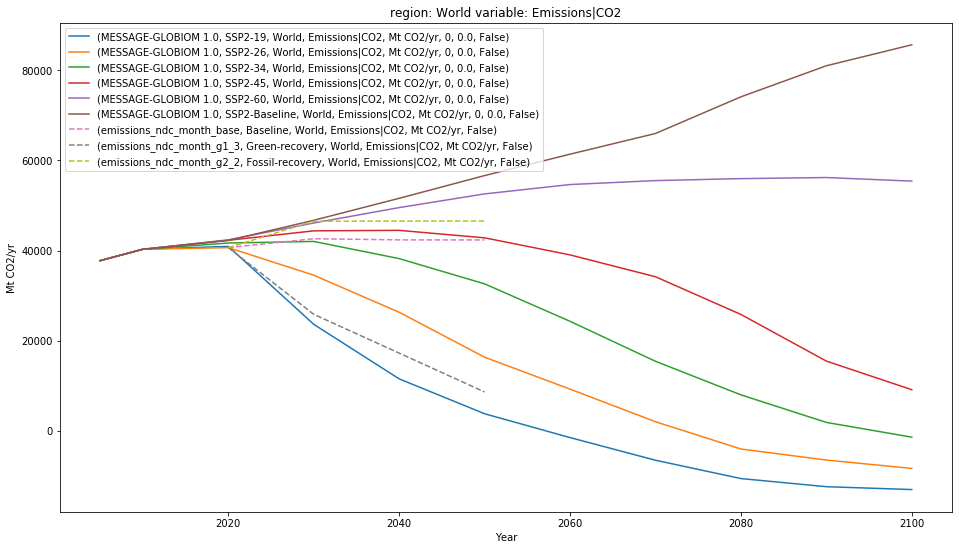

In [25]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
infiller_df.filter(variable=CO2).line_plot(ax=ax)
infilled.filter(variable=CO2).line_plot(ax=ax, linestyle="--")

Once again the lines all fall within the expected limits so we can use the linear infiller for this scenario.

In [26]:
green_add = mi.infill_all_required_variables(
    infilled.filter(scenario='Green-recovery', year=[2040, 2050]), infiller_df, [CO2], 
    desired_vars, 
    dc.LinearInterpolation
)

Filling required variables: 100%|██████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.87it/s]


In [27]:
green_add.timeseries()

2040  \
model                    scenario       region variable                                      unit                            
emissions_ndc_month_g1_3 Green-recovery World  Emissions|BC                                  Mt BC/yr             4.601078   
                                               Emissions|CH4                                 Mt CH4/yr          239.105222   
                                               Emissions|CO                                  Mt CO/yr           646.000484   
                                               Emissions|CO2                                 Mt CO2/yr        17236.721411   
                                               Emissions|CO2|AFOLU                           Mt CO2/yr         -880.091055   
                                               Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        18116.812470   
                                               Emissions|F-Gases                             Mt CO2-equiv/yr    934.336955   
                                               Emissions|N2O                                 kt N2O/yr         9655.959065   
                                               Emissions|NH3                                 Mt NH3/yr           46.074961   
                                               Emissions|NOx                                 Mt NO2/yr           68.050213   
                                               Emissions|OC                                  Mt OC/yr            26.136136   
                                               Emissions|Sulfur                              Mt SO2/yr           30.557407   
                                               Emissions|VOC                                 Mt VOC/yr          156.391518   

                                                                                                                      2050  
model                    scenario       region variable                                      unit                           
emissions_ndc_month_g1_3 Green-recovery World  Emissions|BC                                  Mt BC/yr             4.047675  
                                               Emissions|CH4                                 Mt CH4/yr          212.113761  
                                               Emissions|CO                                  Mt CO/yr           556.350548  
                                               Emissions|CO2                                 Mt CO2/yr         8618.360706  
                                               Emissions|CO2|AFOLU                           Mt CO2/yr        -2173.309893  
                                               Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        10791.670598  
                                               Emissions|F-Gases                             Mt CO2-equiv/yr   1008.279359  
                                               Emissions|N2O                                 kt N2O/yr         8862.648439  
                                               Emissions|NH3                                 Mt NH3/yr           43.048847  
                                               Emissions|NOx                                 Mt NO2/yr           58.273904  
                                               Emissions|OC                                  Mt OC/yr            23.796186  
                                               Emissions|Sulfur                              Mt SO2/yr           25.554893  
                                               Emissions|VOC                                 Mt VOC/yr          141.201147

In [28]:
output = infilled.append(green_add.filter(variable=CO2, keep=False))

# Appending strong green scenario
This scenario is infilled using the IMAGE SSP1 data, based on the common starting point, the SSP1.19 data for 2030 and declining to zero net carbon 0 in 2050. We will construct this by constructing the carbon curve first, then infilling around this. 

In [29]:
greener_base = output.filter(scenario="Green*", year=2020) # We want all the data from 2020
greener_base["scenario"] = "Strong-green"
greener_base = pyam.IamDataFrame(greener_base.data) # This is a workaround for annoying pyam bugs
greener_co2 = greener_base.filter(variable="*CO2")
greener_co2 = pyam.IamDataFrame(greener_co2.data)
greener_co2_ap = greener_co2.copy()
greener_co2_ap.data["value"] = sr15_data.filter(year=2030, variable="*CO2", model="IMAGE*", scenario="SSP1-19")["value"].values
multiple = {2030: 1, 2040: 0.5, 2050: 0} # Note that we accumulate this multiplier, i.e. 2050 gets 1 * 0.5 * 0.
for year in [2030, 2040, 2050]:
    greener_co2_ap["year"] = year
    greener_co2_ap.data["value"] = greener_co2_ap.data["value"] * multiple[year]
    greener_co2.append(greener_co2_ap, inplace=True)
greener_co2 = pyam.IamDataFrame(greener_co2.data).filter(year=2020, keep=False) # We will add the 2020 data back later

In [30]:
greener_co2.data

,model,scenario,region,variable,unit,year,value
1,emissions_ndc_month_g1_3,Strong-green,World,Emissions|CO2,Mt CO2/yr,2030,17967.96826
2,emissions_ndc_month_g1_3,Strong-green,World,Emissions|CO2,Mt CO2/yr,2040,8983.98413
3,emissions_ndc_month_g1_3,Strong-green,World,Emissions|CO2,Mt CO2/yr,2050,0.00000


In [31]:
ssp1_data = sr15_data.filter(scenario="SSP1*", model="IMAGE*")

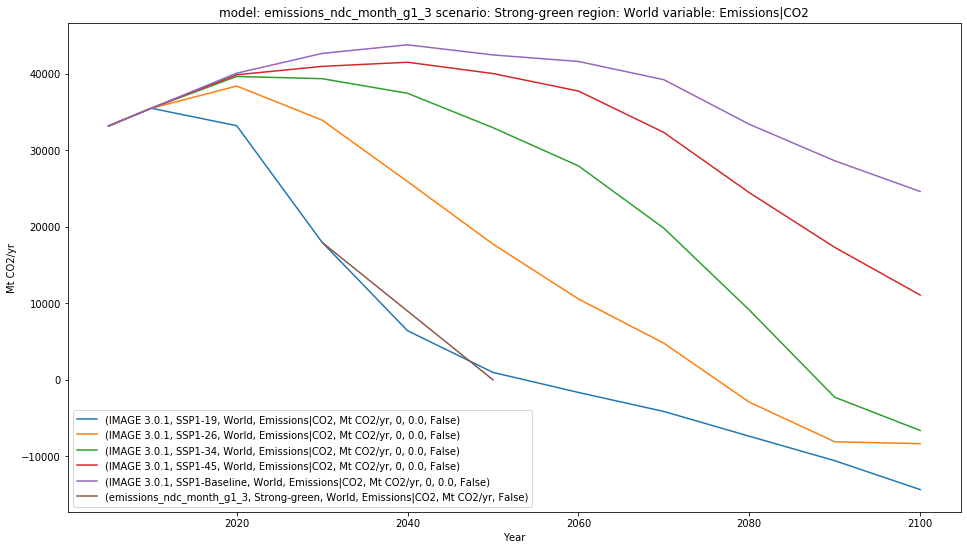

In [32]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ssp1_data.filter(variable=CO2).line_plot(ax=ax)
greener_co2.filter(variable=CO2).line_plot(ax=ax)

The 2050 value of our CO2 is slightly below the lower limit, meaning that non-CO2 values at that point will all use the values of the lower limit.

In [33]:
greener_append = mi.infill_all_required_variables(
    greener_co2, ssp1_data, [CO2], 
    desired_vars, 
    dc.LinearInterpolation
)

Filling required variables: 100%|██████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.64it/s]


In [34]:
greener_append = greener_append.append(greener_base)
greener_append.timeseries()

2020  \
model                    scenario     region variable                                      unit                            
emissions_ndc_month_g1_3 Strong-green World  Emissions|BC                                  Mt BC/yr             5.962082   
                                             Emissions|CH4                                 Mt CH4/yr          330.724996   
                                             Emissions|CO                                  Mt CO/yr           786.902114   
                                             Emissions|CO2                                 Mt CO2/yr        40656.969190   
                                             Emissions|CO2|AFOLU                           Mt CO2/yr         4437.784919   
                                             Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        36219.184280   
                                             Emissions|F-Gases                             Mt CO2-equiv/yr   1491.783333   
                                             Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr  53915.859422   
                                             Emissions|N2O                                 kt N2O/yr         9580.786088   
                                             Emissions|NH3                                 Mt NH3/yr           47.446506   
                                             Emissions|NOx                                 Mt NO2/yr          103.351816   
                                             Emissions|OC                                  Mt OC/yr            30.253298   
                                             Emissions|Sulfur                              Mt SO2/yr           76.106893   
                                             Emissions|VOC                                 Mt VOC/yr          178.092157   

                                                                                                                    2030  \
model                    scenario     region variable                                      unit                            
emissions_ndc_month_g1_3 Strong-green World  Emissions|BC                                  Mt BC/yr             3.990174   
                                             Emissions|CH4                                 Mt CH4/yr          215.384598   
                                             Emissions|CO                                  Mt CO/yr           469.734543   
                                             Emissions|CO2                                 Mt CO2/yr        17967.968260   
                                             Emissions|CO2|AFOLU                           Mt CO2/yr          525.239686   
                                             Emissions|CO2|Energy and Industrial Processes Mt CO2/yr        17442.727580   
                                             Emissions|F-Gases                             Mt CO2-equiv/yr    959.602600   
                                             Emissions|Kyoto Gases (AR5-GWP100)            Mt CO2-equiv/yr           NaN   
                                             Emissions|N2O                                 kt N2O/yr         7595.499998   
                                             Emissions|NH3                                 Mt NH3/yr           64.920241   
                                             Emissions|NOx                                 Mt NO2/yr           62.378103   
                                             Emissions|OC                                  Mt OC/yr            19.670691   
                                             Emissions|Sulfur                              Mt SO2/yr           33.131302   
                                             Emissions|VOC                                 Mt VOC/yr           73.392567   

                                                                                                                   2040  \
model                  

In [35]:
output.append(greener_append, inplace=True)

Recalculate all Kyoto totals for full consistency.

In [36]:
kyoto_results = silicone.utils._construct_consistent_values(
    lead, kyoto_gases, silicone.utils.convert_units_to_MtCO2_equiv(
        output.filter(variable=kyoto_gases), use_ar4_data=use_ar4_data
    )
).timeseries()

pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!
pyam.logging - WARNING: Using a dictionary to convert units is deprecated and will be removed in future versions. Use explicit keyword arguments instead!


In [37]:
output = output.filter(variable=lead, keep=False).append(kyoto_results)

pyam.plotting - INFO: >=13 labels, not applying legend


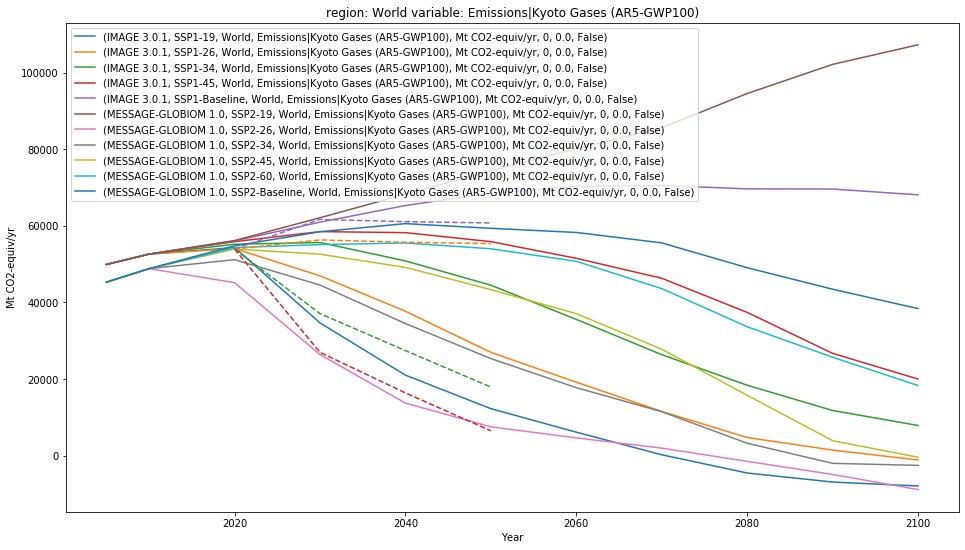

In [38]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
infiller_df.filter(variable=lead).line_plot(ax=ax)
ssp1_data.filter(variable=lead).line_plot(ax=ax)
output.filter(variable=lead).line_plot(ax=ax, linestyle="--")

# Formatting output
Everything is in the correct units, we just need to save it to file. 

In [39]:
output.to_csv("../output/covid_response_infilled_AR{}.csv".format(4 if use_ar4_data else 5))